## **MLP 하이퍼파라미터 튜닝 실험** 🔍

- 다층 퍼셉트론 모델에서 주요 하이퍼파라미터 조정에 따른 성능 변화를 분석하는 실험입니다.
- 본 문서는 해당 실험의 설계, 과정 및 결과를 기술합니다.

> **평가 지표:** 테스트 정확도, 테스트 손실, 총 훈련 시간.

<br>

**실험**
1. 베이스라인 구현
2. 네트워크 구조 (깊이)
3. 네트워크 구조 (너비)
4. 활성화 함수
5. 옵티마이저
6. 학습률

<br>

**사용할 데이터셋**

<img src="https://drive.google.com/uc?id=1B5vd9j6cyJ4Eopde6G--45rA0qkssmVd" width="330">

- **MNIST**: 0부터 9까지의 손글씨 숫자 이미지로 구성된 표준 데이터셋
- **구성**: 60,000개의 학습 데이터와 10,000개의 테스트 데이터
- **형식**: 각 이미지는 28×28 픽셀의 그레이스케일 형식

<br>

---

**작성자**: 2271064 한사랑

## **Import Libraries**

구현에 필요한 핵심 라이브러리를 가져오는 단계

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install torch torchvision

In [2]:
# 데이터 처리 및 수학 연산을 위한 라이브러리
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms  # transforms 추가
from torchvision.transforms import ToTensor

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## **Load and Preprocess Data**
MNIST 데이터셋을 로드하고 전처리하는 단계

- **데이터 로드**: PyTorch의 datasets.MNIST 클래스를 사용하여 손글씨 숫자 이미지 데이터를 다운로드.

- **데이터 분할**: 원본 학습 데이터셋을 8:2 비율로 학습셋과 검증셋으로 나눔.

- **데이터셋 확인**: 각 데이터셋의 크기를 출력하여 확인.

In [ ]:
# -- 제공된 코드 --

# Define transformations: convert images to tensor and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

100.0%
100.0%
100.0%
100.0%


학습 데이터셋 크기: 48000
검증 데이터셋 크기: 12000
테스트 데이터셋 크기: 10000


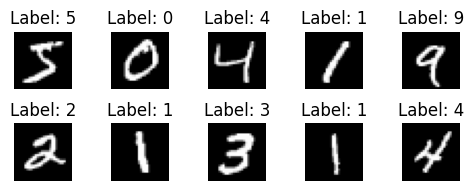

In [5]:
# 학습 데이터셋을 학습/검증 세트로 분할 (8:2 비율)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# DataLoader 생성
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 데이터셋 크기 확인
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"테스트 데이터셋 크기: {len(testset)}")

# MNIST 데이터 시각화
plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img, label = trainset[i]
    img = img.squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## **실험 1: 베이스라인 모델 (Baseline Model)**

**모델 아키텍처**는 다음과 같습니다.

- **입력층**: 784 unit (28×28 픽셀 이미지를 펼친 형태)
- **은닉층 1**: 32 unit, Sigmoid 활성화 함수
- **은닉층 2**: 32 unit, Sigmoid 활성화 함수
- **출력층**: 10 unit (0-9 class)

<br>

### 베이스라인 모델 클래스 정의

In [10]:
class BaselineMLP(nn.Module):
    def __init__(self):
        super(BaselineMLP, self).__init__()
        
        # 네트워크 구조 정의 (입력 784 -> 은닉층 32 -> 은닉층 32 -> 출력 10)
        self.fc1 = nn.Linear(28*28, 32)  # 입력층 -> 첫 번째 은닉층
        self.fc2 = nn.Linear(32, 32)     # 첫 번째 은닉층 -> 두 번째 은닉층
        self.fc3 = nn.Linear(32, 10)     # 두 번째 은닉층 -> 출력층
        
        # 시그모이드 활성화 함수
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 입력 이미지 평탄화 (배치크기, 1, 28, 28) -> (배치크기, 784)
        x = x.view(-1, 28*28)
        
        # 순전파
        x = self.sigmoid(self.fc1(x))  # 첫 번째 은닉층 + 활성화 함수
        x = self.sigmoid(self.fc2(x))  # 두 번째 은닉층 + 활성화 함수
        x = self.fc3(x)                # 출력층
        
        return x
    
# 모델 인스턴스 생성
model = BaselineMLP().to(device)
print(model)

BaselineMLP(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 손실 함수 및 옵티마이저 정의

In [9]:
# 손실 함수 정의 (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (SGD, 학습률=0.1)
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### 모델 학습 및 평가